In [349]:
import itertools
from functools import partial

import collections
import random
import warnings

import numpy as np
import pandas as pd
import pymatgen.symmetry.analyzer

from pymatgen.analysis.local_env import JmolNN
import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ase # Needs to be <= 3.19.3
import swifter

import pymatgen.core.composition
import pymatgen.io.ase
from pymatgen.analysis.local_env import JmolNN

import sklearn.pipeline, sklearn.impute, sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.cluster
import sklearn.decomposition

import matminer
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.structure.misc import EwaldEnergy
from matminer.featurizers.structure.order import StructuralComplexity
from matminer.featurizers.structure.symmetry import GlobalSymmetryFeatures
from matminer.featurizers.structure.bonding import GlobalInstabilityIndex
from matminer.featurizers.site.bonding import AverageBondLength

In [350]:
RANDOM_SEED = 1234
pd.options.mode.chained_assignment = None
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tqdm.tqdm.pandas()

# Read and Clean the Data

The following criteria were applied to filter this data:
- Systems may not contain elements from the f-block or any synthetic elements
- Systems may not contain noble gases
- Systems which had a U-correction appplied were removed. This helps ensure a consistent methodology in the data we're using, as the bandgap is influenced by the U-correction (and indeed, U is often tuned *to reproduce* the experimental bandgap - see this [excellent article](https://www.mdpi.com/2076-3417/11/5/2395) on the process).
- We also restrict ourselves to only Sulfur-containing systems in this notebook, as we'd observed in previous work that they're rather more well-behaved than the other systems in the dataset (while still being relevant to 2D material engineering e.g. MoS2).

In [351]:
dataset_path = "../raw_data/2d_mat_dataset_raw.pkl"
df = pd.read_pickle(dataset_path)

total = len(df)
print(f"Starting with {total} entries. Includes top-down and bottom-up.")

# Remove systems containing f-block / synthetic elements
fblock_and_synth = ["La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu",
                    "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr",
                    "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Tg", "Cn", "Nh", "Fl", "Mc", "Mc", "Lv", "Ts", "Og"]
df = df[df["atoms_object (unitless)"].apply(
           lambda atoms: all(symbol not in fblock_and_synth for symbol in atoms.get_chemical_symbols()))
       ]
print(f"Discarding {total - len(df)} entries in the f-block, or synthetics. Total is now {len(df)}.")
total = len(df)

# Remove systems containing noble gases
nobles = ["He", "Ne", "Ar", "Kr", "Xe", "Rn"]
df = df[df["atoms_object (unitless)"].apply(
           lambda atoms: all(symbol not in nobles for symbol in atoms.get_chemical_symbols()))
       ]
print(f"Discarding {total - len(df)} entries with noble gases. Total is now {len(df)}.")
total = len(df)

# To keep the methodology consistent, discard systems where a U-correction was applied
df = df[df["is_hubbard (unitless)"] == False]
print(f"Discarding {total - len(df)} entries that have U-corrections applied (metal oxides/fluorides). Total is now {len(df)}.")
total = len(df)

# Discard systems that do not contain Sulfur
df = df[df["atoms_object (unitless)"].apply(lambda atoms: "S" in atoms.get_chemical_symbols())]
print(f"Discarding {total - len(df)} entries that don't contain Sulfur. Total is now {len(df)}.")
total = len(df)

Starting with 6351 entries. Includes top-down and bottom-up.
Discarding 562 entries in the f-block, or synthetics. Total is now 5789.
Discarding 2 entries with noble gases. Total is now 5787.
Discarding 679 entries that have U-corrections applied (metal oxides/fluorides). Total is now 5108.
Discarding 4511 entries that don't contain Sulfur. Total is now 597.


# Featurization

Next, we featurized our dataset. We begin by leveraging PyMatGen to estimate the oxidation states of our materials.

In [352]:
structures = df['atoms_object (unitless)'].apply(pymatgen.io.ase.AseAtomsAdaptor.get_structure)
df['ox_struct'] = structures.apply(lambda i: i.copy())

# struct.add_oxidation_state_by_guess() modifies the structure in-place
df.ox_struct.progress_apply(lambda struct: struct.add_oxidation_state_by_guess())

100%|███████████████████████████████████████████████████████████████████████████████████████| 597/597 [01:10<00:00,  8.47it/s]


2       None
15      None
19      None
27      None
28      None
        ... 
6331    None
6332    None
6345    None
6347    None
6349    None
Name: ox_struct, Length: 597, dtype: object

In [353]:
struct_features = MultipleFeaturizer([
    EwaldEnergy(),
    StructuralComplexity(),
    GlobalSymmetryFeatures('n_symmetry_ops'),
])
df[struct_features.feature_labels()] = struct_features.featurize_many(df.ox_struct).copy()

MultipleFeaturizer:   0%|          | 0/597 [00:00<?, ?it/s]

In [354]:
desc = GlobalInstabilityIndex()

def maybe_global_instability(struct):
    try:
        return desc.featurize(struct)[0]
    except:
        return None

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df['global_instability'] = df.ox_struct.progress_apply(maybe_global_instability).copy()

/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/pandas/io/parsers/readers.py:586: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return _read(filepath_or_buffer, kwds)
100%|███████████████████████████████████████████████████████████████████████████████████████| 597/597 [00:12<00:00, 48.57it/s]


In [355]:
neighbor_finder = JmolNN()

def average_bond_length(structure, featurizer = AverageBondLength(neighbor_finder)):
    n_atoms = len(structure)
    try:
        lengths = map(lambda i: featurizer.featurize(structure, i)[0], range(n_atoms))
        return sum(lengths) / n_atoms
    except IndexError:
        return None

df['bond_length_average'] = df.ox_struct.progress_apply(average_bond_length).copy()

100%|███████████████████████████████████████████████████████████████████████████████████████| 597/597 [00:19<00:00, 31.41it/s]


In [356]:
from matminer.featurizers.site.bonding import AverageBondAngle

def average_bond_angle(structure, featurizer = AverageBondAngle(neighbor_finder)):
    n_atoms = len(structure)
    try:
        angles = map(lambda i: featurizer.featurize(structure, i)[0], range(n_atoms))
        return sum(angles) / n_atoms
    except IndexError:
        return None
df['bond_angle_average'] = df.ox_struct.progress_apply(average_bond_angle).copy()

  1%|▋                                                                                        | 5/597 [00:00<00:12, 49.27it/s]/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/matminer/featurizers/site/bonding.py:250: RuntimeWarning: All-NaN slice encountered
  minimum_bond_angles = np.nanmin(bond_angles, axis=1)
100%|███████████████████████████████████████████████████████████████████████████████████████| 597/597 [00:22<00:00, 27.11it/s]


In [357]:
def average_cn(structure, neighbor_finder = neighbor_finder):
    n_atoms = len(structure)
    cns = map(lambda i: neighbor_finder.get_cn(structure, i), range(n_atoms))
    return sum(cns) / n_atoms
df['average_cn'] = df.ox_struct.progress_apply(average_cn).copy()

100%|███████████████████████████████████████████████████████████████████████████████████████| 597/597 [00:21<00:00, 28.09it/s]


In [358]:
def ab_perimeter_area_ratio(structure):
    a, b, c = structure.lattice.matrix
    perimeter = 2*np.linalg.norm(a) + 2*np.linalg.norm(b)
    area = np.linalg.norm(np.cross(a,b))
    return perimeter / area
df['perimeter_area_ratio'] = df.ox_struct.progress_apply(ab_perimeter_area_ratio).copy()

100%|████████████████████████████████████████████████████████████████████████████████████| 597/597 [00:00<00:00, 16284.69it/s]


In [359]:
df["formula"] = df["atoms_object (unitless)"].progress_apply(lambda atoms: atoms.get_chemical_formula(empirical=True))

100%|████████████████████████████████████████████████████████████████████████████████████| 597/597 [00:00<00:00, 37892.88it/s]


# Symbol / Length / Angle Features

Taking inspiration from the work of Bhowmik, R. et al in doi.org/10.1016/j.polymer.2021.123558, we incorporate as features:
- The number of elements in per crystal unit (e.g. number of C, H, N, etc).
- The number of element-element bonds per crystal unit (e.g. number of C-C, C-H, C-N, H-N, H-H, N-N, etc bonds).
- The number of element-element-element angles per crystal unit (e.g. number of C-C-H, C-H-C, C-C-C, etc angles).

In [360]:
classes = {
'alkaline' : ['H', 'Li', 'Na', 'K', 'Rb', 'Cs', 'Fr'],
'alkaine_earth' : ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra'],
'early_transition' : ['Sc', 'Ti', 'V', 'Cr', 'Mn',
                    'Y', 'Zr', 'Nb', 'Mo', 'Tc',
                    'Hf', 'Ta', 'W', 'Re', 'Os'],
'late_transition' : ['Fe', 'Co', 'Ni', 'Cu', 'Zn',
                   'Ru', 'Rh', 'Pd', 'Ag', 'Cd',
                   'Os', 'Ir', 'Pt', 'Au', 'Hg'],
'triel' : ['B', 'Al', 'Ga', 'In', 'Tl'],
'tetrel' : ['C', 'Si', 'Ge', 'Sn', 'Pb'],
'pnictogen' : ['N', 'P', 'As', 'Sb', 'Bi'],
'chalcogen' : ['O', 'S', 'Se', 'Te', 'Po'],
'halide' : ['F', 'Cl', 'Br', 'I', 'At']
    
}

groups = {}
for key, values in classes.items():
    for val in values:
        groups[val] = key

It's a little inefficient since we're doing some heavy calculations twice, but we start off by figuring out which symbol/length/angle columns we'll even need

In [361]:
symbols_cols = collections.Counter()
bond_cols = collections.Counter()
angle_cols = collections.Counter()

neighbor_finder = JmolNN()

with tqdm.tqdm(total=len(df)) as pbar:
    for struct in df["ox_struct"]:
        symbols_cols.update([groups[symbol] for symbol in struct.symbol_set])
        
        for index, site in enumerate(struct.sites):
            connected = [i['site'] for i in neighbor_finder.get_nn_shell_info(struct, index, 1)]
            
            # Bond counts
            for vertex in connected:
                start, end = sorted([groups[str(site.specie.element)], groups[str(vertex.specie.element)]])
                bond = f"{start}-{end}"
                bond_cols[bond] += 0.5
                
            # Angles
            for angle_start, angle_end in map(sorted, itertools.combinations(connected,2)):
                angle = f"{groups[str(angle_start.specie.element)]}-{groups[str(site.specie.element)]}-{groups[str(angle_end.specie.element)]}"
                angle_cols[angle] += 1
        pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████████████| 597/597 [07:23<00:00,  1.35it/s]


Here, we walk through the elements in the crystal to count the symbols / lengths / angles. For each atom `i`, we:

1) Incrememnt the relevant atomic symbol count by 1.
2) Calculate a list of first-nearest-neighbors for the atom.
3) For each neighbor `j`, increment the `i-j` bond count by 0.5 (since otherwise, we double-count). To ensure this is permutation-independent (e.g. H-C being counted separately from C-H), we order i and j alphabetically (e.g. H-C would be represented as C-H instead).
4) For each possible length-2 combination of neighbors (`j` and `k`), we increment the `j-i-k` angle count (e.g. the C-H-C angle). To again ensure this is permutation-independent, we alphabetize `j` and `k` beforehand. Double counting is not a possibility here, because we only visit each center atom (the `i` in a `j-i-k` angle) once.

In [362]:
tqdm.tqdm.pandas()
all_symbols = set(symbols_cols.keys())
all_bonds = set(bond_cols.keys())
all_angles = set(angle_cols.keys())

def featurize(data):
    symbol_units = "atoms"
    bond_units = "bonds"
    angle_units = "angles"
    struct = data["ox_struct"]
    
    present_symbols = collections.Counter([groups[symbol] for symbol in struct.symbol_set])
    present_bonds = collections.Counter()
    present_angles = collections.Counter()
    
    # Record and Count Symbols
    for symbol, count in present_symbols.items():
        data[f"{symbol} ({symbol_units})"] = count
    data[f"Total Atoms ({symbol_units})"] = sum(present_symbols.values())
    
    for index, site in enumerate(struct.sites):
        connected = [i['site'] for i in neighbor_finder.get_nn_shell_info(struct, index, 1)]
        
        # Count Bonds
        for vertex in connected:
            start, end = sorted([groups[str(site.specie.element)], groups[str(vertex.specie.element)]])
            bond = f"{start}-{end}"
            present_bonds[bond] += 0.5
            
        # Count Angles
        for angle_start, angle_end in map(sorted, itertools.combinations(connected, 2)):
            angle = f"{groups[str(angle_start.specie.element)]}-{groups[str(site.specie.element)]}-{groups[str(angle_end.specie.element)]}"
            present_angles[angle] += 1
            
    # Record Bonds
    for bond, count in present_bonds.items():
        data[f"{bond} ({bond_units})"] = count
    data[f"Total Bonds ({bond_units})"] = sum(present_bonds.values())
            
    # Record Angles
    for angle, count in present_angles.items():
        data[f"{angle} ({angle_units})"] = count
    data[f"Total Angles ({angle_units})"] = sum(present_angles.values())
    
    return data

all_data_features = df.progress_apply(featurize, axis=1)
all_data_features

100%|███████████████████████████████████████████████████████████████████████████████████████| 597/597 [07:22<00:00,  1.35it/s]


,2dm_id (unitless),Total Angles (angles),Total Atoms (atoms),Total Bonds (bonds),alkaine_earth (atoms),alkaine_earth-chalcogen (bonds),alkaine_earth-chalcogen-alkaine_earth (angles),alkaine_earth-chalcogen-early_transition (angles),alkaine_earth-chalcogen-triel (angles),alkaline (atoms),...,var:num_unfilled,var:num_valance,var:period,var:sound_velocity,var:specific_heat,var:thermal_conductivity,var:vdw_radius,var:vdw_radius_alvarez,var:vdw_radius_mm3,var:vdw_radius_uff
2,2dm-3,54,2,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.250000,110.250000,2.250000,2.262728e+06,0.091204,524.295506,64.000000,841.000000,484.000000,243.360000
15,2dm-16,21,2,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.222222,64.222222,2.000000,2.215678e+05,0.079734,4986.342672,242.000000,600.888889,98.000000,3173.388889
19,2dm-20,39,2,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.836735,1.836735,0.000000,3.309938e+05,0.005760,11250.753474,3.265306,264.489796,90.000000,439.379592
27,2dm-28,234,2,27.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.918367,0.000000,0.979592,1.368063e+06,0.056660,4717.727027,335.265306,768.000000,141.061224,2366.422041
28,2dm-29,4,2,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.250000,30.250000,0.250000,4.616258e+05,0.042830,0.001806,6.250000,2.250000,12.250000,59.290000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,2dm-6351,28,2,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,121.000000,2.250000,1.646697e+06,0.082082,302.673006,121.000000,1260.250000,870.250000,171.610000
6332,2dm-6352,51,2,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.160000,11.760000,0.240000,2.833020e+05,0.031104,198.996486,11.760000,443.760000,230.640000,290.649600
6345,2dm-6365,6,2,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,100.000000,2.250000,1.463463e+06,0.088209,16.382256,462.250000,784.000000,361.000000,4422.250000
6347,2dm-84,36,2,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,81.000000,2.250000,3.286004e+05,0.089700,1288.630506,272.250000,400.000000,144.000000,4102.402500


# Train/Test Split and Clustering

Now that we're done featurizing, we can begin analyzing our data. To begin, well take a train / test split.

In [318]:
to_fill = [col for col in all_data_features.columns if any([col.endswith('(atoms)'), col.endswith('(bonds)'), col.endswith('(angles)')])]
all_data_features[to_fill] = all_data_features[to_fill].fillna(0)

train, test = sklearn.model_selection.train_test_split(all_data_features, test_size=0.1, random_state=RANDOM_SEED)

# K-Means and SOAP

Next, we'll incorporate structural information by way of K-Means clustering on the Smooth Overlap of Atomic Positions (SOAP) fingerprint.

## SOAP
SOAP (documentation link [here](https://singroup.github.io/dscribe/latest/tutorials/descriptors/soap.html)) will generate an `m` x `n` matrix from the atomic coordinates, where `m` is the number of atoms in the system and `n` is SOAP's encoding for the atom. Because we want a vector and not a matrix for each structure, we concatenate the average, minimum, and maximum of each column of the SOAP encoding for the atoms in the system. This generates a vector of length `3n`.

In [319]:
import dscribe.descriptors

symbols = range(1,93)

soap = dscribe.descriptors.SOAP(species=symbols,
                                periodic=True,
                                rcut=4,
                                nmax=2,
                                lmax=4)
def saponify(atoms):
    lathered = soap.create(atoms)
    # Soap creates an N x M array
    #     - N is the number of atoms in the system
    #     - M is the size of the SOAP descriptor 
    # So we'll average along the N direction
    rinsed = np.hstack([lathered.mean(axis=0), lathered.min(axis=0), lathered.max(axis=0)])
    return rinsed

## PCA

SOAP generates some rather large feature vectors. Part of this is because we consider atoms up to atomic number 92 (U).

The extremely high-dimensional space this creates (255,300 dimensions!) is very problematic for us. The K-means implementation we're using leverages the Euclidean distance to create its clusters - and doesn't allow for other distance metrics. This creates a problem for us: as Aggarwal, C. C. points out in "[On the Surprising Behavior of Distance Metrics in High Dimensional Space](https://doi.org/10.1007/3-540-44503-X_27)", in high dimensional spaces, the Manhattan (L1) distance is *significantly* more meaningful in assessing proximity than the Euclidean (L2) distance.

As a result, we'll instead reduce the dimensionality of our problem via PCA - this is especially useful, as the SOAP vectors we create are also rather sparse. Somewhat arbitrarily, we will take the first 128 principle components of the data.

In [320]:
cluster_training_data = np.vstack(train['atoms_object (unitless)'].progress_apply(saponify).to_numpy())
print(cluster_training_data.shape)

pca = sklearn.decomposition.PCA(n_components=128)
cluster_training_data = pca.fit_transform(cluster_training_data)
print(cluster_training_data.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 348/348 [00:05<00:00, 62.02it/s]


(348, 255300)
(348, 128)


Another major reason to use PCA is that it gives us a compressed representation of the variance of our feature space. PCA works by providing vectors containing the highest (PCA component 0), next-highest, (component 1), and so-on variance in the feature space. We demonstrate this by plotting the range of the data in the below plot - we see a much greater variation in the data at higher dimensions compared to low dimensions.

This synergizes very well with K-means, as the algorithm attempts to find clusters whose groups contain equal variance.

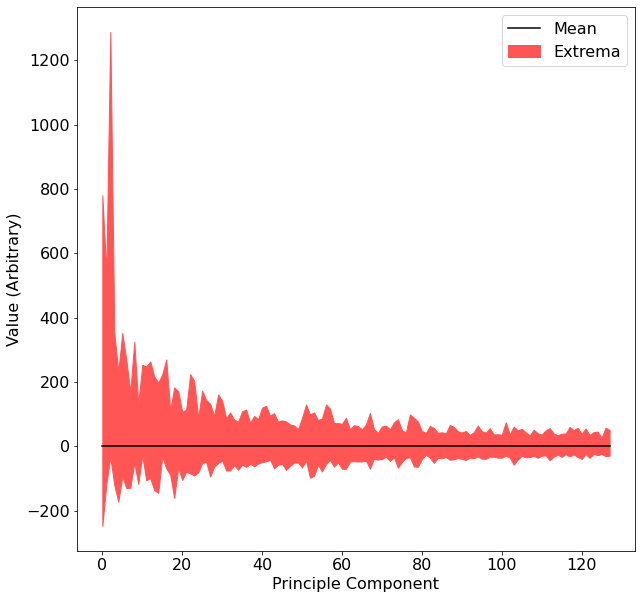

In [321]:
plt.plot(cluster_training_data.mean(axis=0), c='k', label="Mean")
plt.fill_between(range(cluster_training_data.shape[1]), cluster_training_data.min(axis=0), cluster_training_data.max(axis=0), color='#FF5555', label="Extrema")
plt.xlabel("Principle Component")
plt.ylabel("Value (Arbitrary)")
plt.legend()

## K-Means

Because we're programmers, and enjoy automating things, we'll algorithmically find an optimal K for the clustering. To do this, we take advantage of the [Calinski-Harabasz Score](https://arxiv.org/abs/1905.05667), which rates higher clusters which:
1. Maximizes the distance between members of different clusters.
2. Minimizes the distance between members of the same cluster.

We then plot this score as a function of K, seeking to maximize it.

N_Clusters	Error
2		62.57941604416389
3		74.33988609340612
4		78.10544410217344
5		75.17371087368288
6		71.88205451129124
7		65.75295204326265
8		64.73116767670929
9		61.706364948150394
10		58.65782889354289
11		56.99626936921579
12		52.71632481282155
13		50.13179880136763
14		49.96687628344591
15		46.63496603501496
16		45.35048442032377
17		43.075711342160304
18		43.920007785277555
19		41.75978896164525
20		40.571635557277816
21		39.44508162486968
22		38.04894247199577
23		37.2624605568629
24		36.78654962404895
25		35.29328200899165
26		34.176539295263005
27		34.6524918604801
28		32.85058508026045
29		32.500116472440986
30		32.33981976057825
31		32.19754423509088


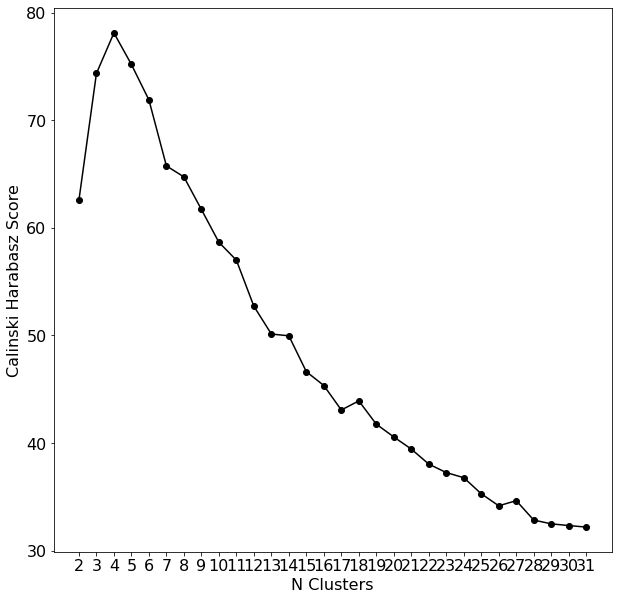

In [322]:
results = {}
min_clusters = 2
max_clusters = 32
n_skip = 1
print("N_Clusters\tError")
for n_clusters in np.arange(min_clusters, max_clusters, n_skip):
    clusters = sklearn.cluster.KMeans(n_clusters=n_clusters,
                                      n_init=16,
                                      random_state=RANDOM_SEED)
    clusters.fit(cluster_training_data)
    error = sklearn.metrics.calinski_harabasz_score(cluster_training_data, clusters.predict(cluster_training_data))
    results[n_clusters] = error
    print(n_clusters, error, sep="\t\t")
    
plt.plot(list(results.keys()), list(results.values()), marker="o", color="black")
plt.xticks(range(min_clusters, max_clusters))
plt.xlabel("N Clusters")
plt.ylabel("Calinski Harabasz Score")
plt.show()

We see that we reach an optimum at K=4.

One more thing we need to do. We want to avoid a scenario where only 2-3 points have been assigned to the same cluster, as this creates problems when we try to evaluate certain metrics like R2, and is also problematic for cross validation in multitask SISSO. It also isn't particularly useful to train a model on that few points.

So, first, we'll check the number of points in each cluster. If there are not enough labels, we'll drop down to the next-lowest number of cluster.

In this case, we see that our optimum of K=4 is fine.

In [323]:
n_clusters = max(results, key=results.get)
print(n_clusters)

clusters = sklearn.cluster.KMeans(n_clusters=n_clusters,
                                  n_init=8,
                                  random_state=RANDOM_SEED)
clusters.fit(cluster_training_data)

labels = collections.Counter(clusters.predict(cluster_training_data))

# We can't actually run SISSO on the dataset if we don't have enough examples for all task labels
while any([count < 4 for count in labels.values()]):
    n_clusters -= 1
    clusters = sklearn.cluster.KMeans(n_clusters=n_clusters,
                                      n_init=8,
                                      random_state=42)
    clusters.fit(cluster_training_data)
    labels = collections.Counter(clusters.predict(cluster_training_data))
print(n_clusters)

4
4


Next, label each cluster based on the cluster they belong to.

In [324]:
cluster_test = np.vstack(test['atoms_object (unitless)'].progress_apply(saponify).to_numpy())
train['soap_label'] = clusters.predict(cluster_training_data)
test['soap_label'] = clusters.predict(pca.transform(cluster_test))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.42it/s]


Finally, we'll check to make sure that we do actually represent all 4 clusters in the training and testing set:

In [325]:
collections.Counter(train['soap_label'])

Counter({1: 21, 3: 51, 2: 46, 0: 230})

In [326]:
collections.Counter(test['soap_label'])

Counter({0: 23, 3: 6, 1: 5, 2: 5})

# Feature Selection

Next, we will use Random-Forest feature selection to determine which features to include for SISSO. We begin by dropping several columns that we do not want to include with SISSO, such as DFT-calculated properties like the decomposition energy.

In [69]:
object_cols = ["atoms_object (unitless)",
               "ox_struct"]

regression_irrelevant = object_cols + [
    'discovery_process (unitless)',
    'potcars (unitless)',
    'is_hubbard (unitless)',
    'energy_per_atom (eV)',
    'decomposition_energy (eV/atom)',
    'is_bandgap_direct (unitless)',
    'is_metal (unitless)',
    'energy_vdw_per_atom (eV/atom)',
    'total_magnetization (Bohr Magneton)']

Next, we hold out a validation set (called `data_test` below) and train a Random-Forest model on each K.

In [222]:
data_train, data_test = sklearn.model_selection.train_test_split(train[train['soap_label']==1].drop(columns=regression_irrelevant + ['formula', '2dm_id (unitless)', 'exfoliation_energy_per_atom (eV/atom)']).fillna(0), 
                                                                 test_size=0.1, random_state=RANDOM_SEED)

train_x = data_train.drop(columns=["bandgap (eV)", 'soap_label']).to_numpy()
train_y = data_train["bandgap (eV)"].to_numpy()

val_x = data_test.drop(columns=["bandgap (eV)", 'soap_label']).to_numpy()
val_y = data_test["bandgap (eV)"].to_numpy()

model = sklearn.pipeline.Pipeline(
    [("Scaler", sklearn.preprocessing.MinMaxScaler()),
     ("Ensemble", sklearn.ensemble.RandomForestRegressor(n_estimators = 100, max_features=50))
    ]
)

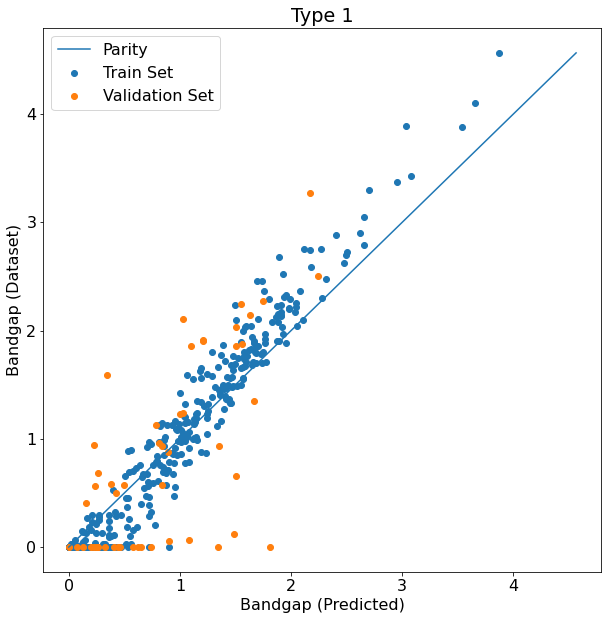

In [224]:
model.fit(X=train_x, y=train_y)

train_y_pred = model.predict(train_x)
val_y_pred = model.predict(val_x)

# Plot the results   
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 16

plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
plt.scatter(x=val_y_pred, y=val_y, label="Validation Set")
min_xy = min(min(train_y_pred), min(train_y))
max_xy = max(max(train_y_pred), max(train_y))

plt.title("Type 1")
plt.plot([min_xy,max_xy], [min_xy,max_xy], label="Parity")
plt.ylabel("Bandgap (Dataset)")
plt.xlabel("Bandgap (Predicted)")
plt.legend()
plt.show()

In [225]:
data_train, data_test = sklearn.model_selection.train_test_split(train[train['soap_label']==0].drop(columns=regression_irrelevant + ['formula', '2dm_id (unitless)', 'exfoliation_energy_per_atom (eV/atom)']).fillna(0), 
                                                                 test_size=0.1, random_state=RANDOM_SEED)

train_x = data_train.drop(columns=["bandgap (eV)", 'soap_label']).to_numpy()
train_y = data_train["bandgap (eV)"].to_numpy()

val_x = data_test.drop(columns=["bandgap (eV)", 'soap_label']).to_numpy()
val_y = data_test["bandgap (eV)"].to_numpy()

model = sklearn.pipeline.Pipeline(
    [("Scaler", sklearn.preprocessing.MinMaxScaler()),
     ("Ensemble", sklearn.ensemble.RandomForestRegressor(n_estimators = 100, max_features=50))
    ]
)

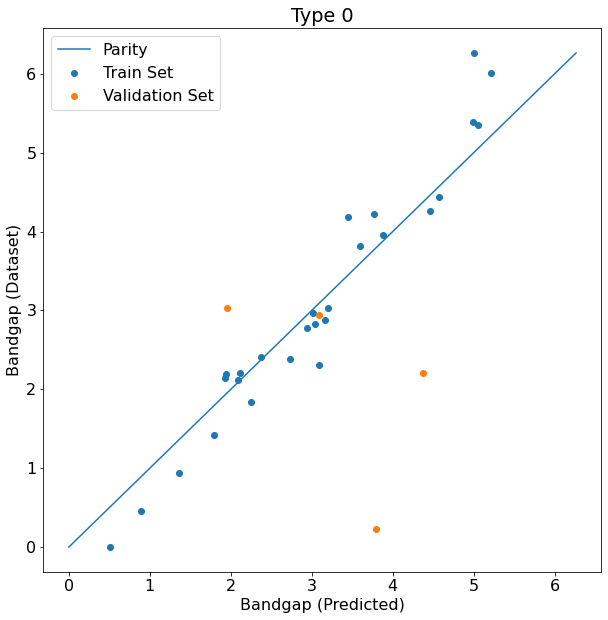

In [226]:
model.fit(X=train_x, y=train_y)

train_y_pred = model.predict(train_x)
val_y_pred = model.predict(val_x)

# Plot the results   
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 16

plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
plt.scatter(x=val_y_pred, y=val_y, label="Validation Set")
min_xy = min(min(train_y_pred), min(train_y))
max_xy = max(max(train_y_pred), max(train_y))

plt.title("Type 0")
plt.plot([min_xy,max_xy], [min_xy,max_xy], label="Parity")
plt.ylabel("Bandgap (Dataset)")
plt.xlabel("Bandgap (Predicted)")
plt.legend()
plt.show()

In [76]:
importances = list(sorted(zip(data_train.drop(columns="bandgap (eV)").columns, model[1].feature_importances_), key=lambda i: -i[1]))
mutual_information = list(sorted(zip(data_train.drop(columns="bandgap (eV)").columns, sklearn.feature_selection.mutual_info_regression(train_x, train_y)), key=lambda i: -i[1]))

In [77]:
n_features = 25

importants = set([i[0] for i in importances[:n_features]])
mutual_infos = set([i[0] for i in mutual_information[:n_features]])

set.intersection(importants, mutual_infos)

{'ave:atomic_number',
 'ave:atomic_weight',
 'ave:period',
 'sum:Polarizability',
 'sum:num_p_unfilled',
 'sum:sound_velocity',
 'var:c6_gb'}

In [78]:
exported_features = [i[0] for i in importances[:n_features]]
print(exported_features)

['ave:atomic_number', 'sum:sound_velocity', 'sum:specific_heat', 'max:c6_gb', 'sum:num_p_unfilled', 'min:atomic_weight', 'sum:hhi_r', 'average_cn', 'sum:heat_capacity_mass', 'sum:gs_est_bcc_latcnt', 'ave:period', 'sum:atomic_radius_rahm', 'ave:num_valance', 'sum:Polarizability', 'ave:atomic_weight', 'sum:vdw_radius_mm3', 'sum:covalent_radius_pyykko_triple', 'sum:melting_point', 'var:sound_velocity', 'min:atomic_number', 'var:electron_negativity', 'ave:specific_heat', 'sum:heat_of_formation', 'sum:en_pauling', 'var:c6_gb']


In [151]:
train_export = train[['bandgap (eV)', 'soap_label'] + exported_features].fillna(0).sort_values('soap_label')
#train_export.to_csv('data_train_featurized_sulfurUnrestricted_soap_importances_bandgap.csv')

In [152]:
test_export = test[['bandgap (eV)', 'soap_label'] + exported_features].fillna(0).sort_values('soap_label')
#test_export.to_csv('data_test_featurized_sulfurUnrestricted_soap_importances_bandgap.csv')

# SISSO Models

In [157]:
#R1D1
r1d1_t0 = lambda df: 1.850631418740413e+00 + \
           1.560888804033170e-11 * (df['var:sound_velocity'] * df['sum:hhi_r'])
r1d1_t1 = lambda df: 7.593072978523676e-01 + 8.053457188249878e-13 * (df['var:sound_velocity'] * df['sum:hhi_r'])

#R1D2
r1d2_t0 = lambda df: 2.846720668897464e+00 + \
           -1.002110960463248e+00 * (df['average_cn'] / df['ave:period']) + \
           1.476693682392120e-11 * (df['var:sound_velocity'] * df['sum:hhi_r'])
r1d2_t1 = lambda df: 1.755560174422515e+00 + -9.219908571141404e-01 * (df['average_cn'] / df['ave:period']) + \
           7.687571882326259e-13 * (df['var:sound_velocity'] * df['sum:hhi_r'])

# R1D3 
r1d3_t0 = lambda df: 3.336572064073060e+00 + \
           7.765011870062933e-05 * (df['sum:heat_of_formation'] * df['average_cn']) + \
           -2.258678345200038e+00 * (df['average_cn'] / df['ave:period']) + \
           1.181395466097512e-11 * (df['var:sound_velocity'] * df['sum:hhi_r'])
r1d3_t1 = lambda df: 1.779675579057679e+00 + \
           -1.293263119117848e-05 * (df['sum:heat_of_formation'] * df['average_cn']) + \
           -7.968776670442069e-01 * (df['average_cn'] / df['ave:period']) + \
           9.117578085106980e-13 * (df['var:sound_velocity'] * df['sum:hhi_r'])

# R1D4
r1d4_t0 = lambda df:4.827220821512196e+00 + \
          -1.915451480137068e-01 * abs(df['sum:en_pauling'] - df['sum:gs_est_bcc_latcnt']) + \
          1.184567860422892e-04 * (df['sum:heat_of_formation'] * df['average_cn']) + \
          -3.594619637535246e+00 * (df['average_cn'] / df['ave:period']) + \
          1.174504091334793e-11 * (df['var:sound_velocity'] * df['sum:hhi_r'])
r1d4_t1 = lambda df: 1.600949474929033e+00 + \
          8.833146157869971e-03 * abs(df['sum:en_pauling'] - df['sum:gs_est_bcc_latcnt']) + \
           -1.985610749739964e-05 * (df['sum:heat_of_formation'] * df['average_cn']) + \
          -6.663877215670986e-01 * (df['average_cn'] / df['ave:period']) + \
           9.393695287462473e-13 * (df['var:sound_velocity'] * df['sum:hhi_r'])

# R2D1
r1d1_t0 = lambda df: -9.348742838125810e-01 +\
           3.656079572576012e+00 * ((df['sum:num_p_unfilled'] / df['sum:gs_est_bcc_latcnt'])+(df['ave:specific_heat'] * df['var:electron_negativity']))
r1d1_t1 = lambda df: -1.780585286402868e-01 +\
           1.473338756072956e+00 * ((df['sum:num_p_unfilled'] / df['sum:gs_est_bcc_latcnt'])+(df['ave:specific_heat'] * df['var:electron_negativity']))

# R2D2
r2d2_t0 = lambda df: -3.237441842433513e-01 +\
           -2.014921555491347e+00 + abs((df['ave:period'] / df['average_cn']) - (df['sum:heat_of_formation'] / df['sum:melting_point'])) +\
           3.940275314156243e+00 * ((df['sum:num_p_unfilled'] / df['sum:gs_est_bcc_latcnt']) + (df['ave:specific_heat'] * df['var:electron_negativity']))
r2d2_t1 = lambda df: -3.479715321513178e-01 +\
           4.283831194623857e-01 + abs((df['ave:period'] / df['average_cn']) - (df['sum:heat_of_formation'] / df['sum:melting_point'])) +\
           1.313019627531759e+00 * ((df['sum:num_p_unfilled'] / df['sum:gs_est_bcc_latcnt']) + (df['ave:specific_heat'] * df['var:electron_negativity']))

# R2D3
r2d3_t0 = lambda df: 4.488510497104689e-01 +\
           -1.843752123832672e+00 + abs((df['ave:period'] / df['average_cn']) - (df['sum:heat_of_formation'] / df['sum:melting_point'])) +\
           2.846878471611191e-05 * (np.sqrt(df['var:sound_velocity']) * (df['var:electron_negativity'] * df['sum:specific_heat'])) +\
          2.723558937301273e+00 * ((df['sum:num_p_unfilled'] / df['sum:gs_est_bcc_latcnt']) + (df['ave:specific_heat'] * df['var:electron_negativity']))
r2d3_t1 = lambda df: -2.091580173350305e-01 +\
           3.215177162451530e-01 + abs((df['ave:period'] / df['average_cn']) - (df['sum:heat_of_formation'] / df['sum:melting_point'])) +\
           4.494951906226667e-05 * (np.sqrt(df['var:sound_velocity']) * (df['var:electron_negativity'] * df['sum:specific_heat'])) +\
          1.116715961404604e+00 * ((df['sum:num_p_unfilled'] / df['sum:gs_est_bcc_latcnt']) + (df['ave:specific_heat'] * df['var:electron_negativity']))

In [158]:
def fun_branch(fun0, fun1, df):
    if df['soap_label'] == 0:
        return fun0(df)
    elif df['soap_label'] == 1:
        return fun1(df)

train_export['r1d1'] = train_export.apply(partial(fun_branch, r1d1_t0, r1d1_t1), axis=1)
train_export['r1d2'] = train_export.apply(partial(fun_branch, r1d2_t0, r1d2_t1), axis=1)
train_export['r1d3'] = train_export.apply(partial(fun_branch, r1d3_t0, r1d3_t1), axis=1)
train_export['r1d4'] = train_export.apply(partial(fun_branch, r1d4_t0, r1d4_t1), axis=1)

train_export['r2d1'] = train_export.apply(partial(fun_branch, r2d1_t0, r2d1_t1), axis=1)
train_export['r2d2'] = train_export.apply(partial(fun_branch, r2d2_t0, r2d2_t1), axis=1)
train_export['r2d3'] = train_export.apply(partial(fun_branch, r2d3_t0, r2d3_t1), axis=1)

test_export['r1d1'] = test_export.apply(partial(fun_branch, r1d1_t0, r1d1_t1), axis=1)
test_export['r1d2'] = test_export.apply(partial(fun_branch, r1d2_t0, r1d2_t1), axis=1)
test_export['r1d3'] = test_export.apply(partial(fun_branch, r1d3_t0, r1d3_t1), axis=1)
test_export['r1d4'] = test_export.apply(partial(fun_branch, r1d4_t0, r1d4_t1), axis=1)

test_export['r2d1'] = test_export.apply(partial(fun_branch, r2d1_t0, r2d1_t1), axis=1)
test_export['r2d2'] = test_export.apply(partial(fun_branch, r2d2_t0, r2d2_t1), axis=1)
test_export['r2d3'] = test_export.apply(partial(fun_branch, r2d3_t0, r2d3_t1), axis=1)

/var/folders/44/wt0537cs00g919dkdsfqdq8w0000gn/T/ipykernel_72450/986519234.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  4.283831194623857e-01 + abs((df['ave:period'] / df['average_cn']) - (df['sum:heat_of_formation'] / df['sum:melting_point'])) +\
/var/folders/44/wt0537cs00g919dkdsfqdq8w0000gn/T/ipykernel_72450/986519234.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  3.215177162451530e-01 + abs((df['ave:period'] / df['average_cn']) - (df['sum:heat_of_formation'] / df['sum:melting_point'])) +\


In [163]:
train_export = train_export.replace([np.inf, -np.inf], np.nan)
test_export = test_export.replace([np.inf, -np.inf], np.nan)

In [164]:
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['font.size'] = 16

In [243]:
def make_plot(colname):    
    train_t0 = train_export[train_export['soap_label'] == 0]
    train_t1 = train_export[train_export['soap_label'] == 1]
    test_t0 = test_export[test_export['soap_label'] == 0]
    test_t1 = test_export[test_export['soap_label'] == 1]

    plt.scatter(x=train_t0[colname], y=train_t0['bandgap (eV)'], label="Train_Type0", marker='o', c='#FFAAAA')
    plt.scatter(x=train_t1[colname], y=train_t1['bandgap (eV)'], label="Train_Type1", marker='o', c='#AAAAFF')
    
    plt.scatter(x=test_t0[colname], y=test_t0['bandgap (eV)'], label="Test_Type0", marker='o',    c='#FF0000')
    plt.scatter(x=test_t1[colname], y=test_t1['bandgap (eV)'], label="Test_Type1", marker='o',    c='#0000FF')
    lims = [min(min(train_export[colname]), min(train_export['bandgap (eV)'])),
            max(max(train_export[colname]), max(train_export['bandgap (eV)']))]
    plt.plot([lims[0],lims[1]], [lims[0],lims[1]], label="Parity", ls='--', c='k')
    
    plt.title(colname)
    plt.ylabel("Bandgap (Actual)")
    plt.xlabel("Bandgap (Predicted)")
    plt.legend()
    plt.show()

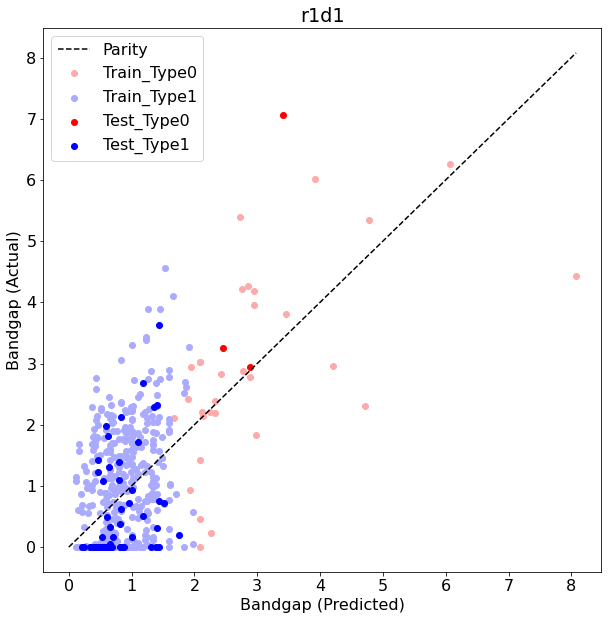

In [244]:
make_plot('r1d1')

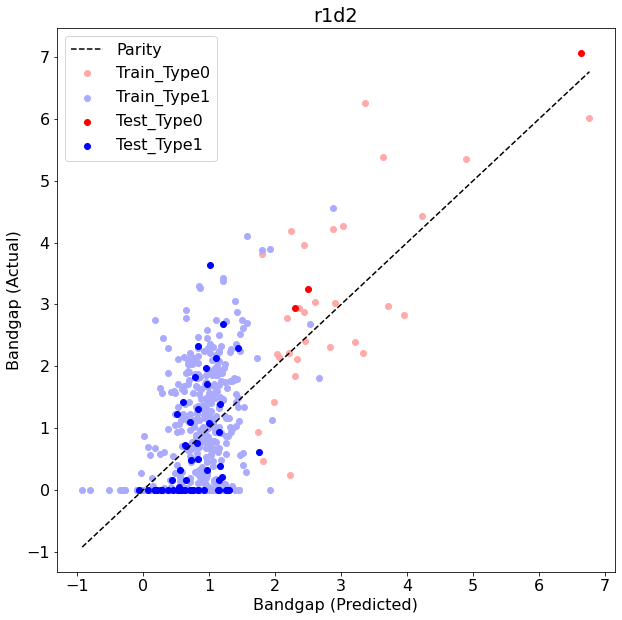

In [245]:
make_plot('r1d2')

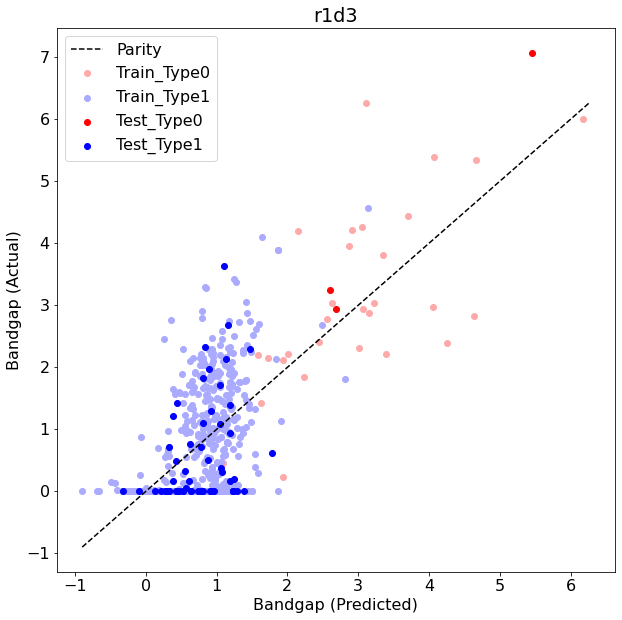

In [246]:
make_plot('r1d3')

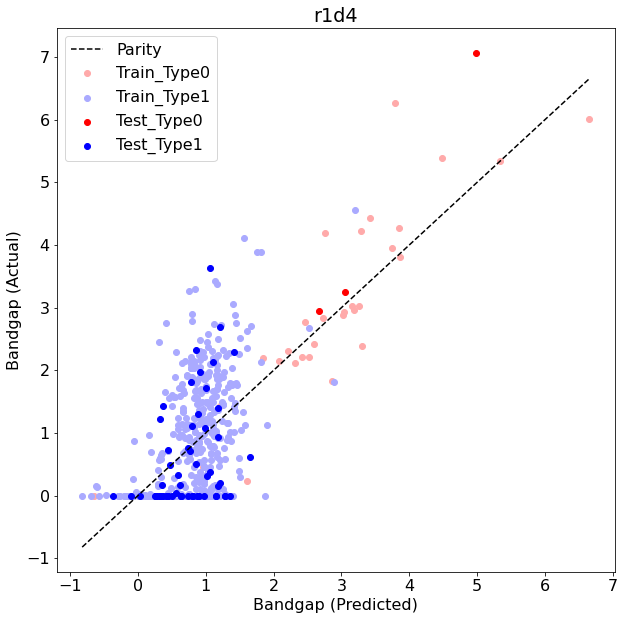

In [247]:
make_plot('r1d4')

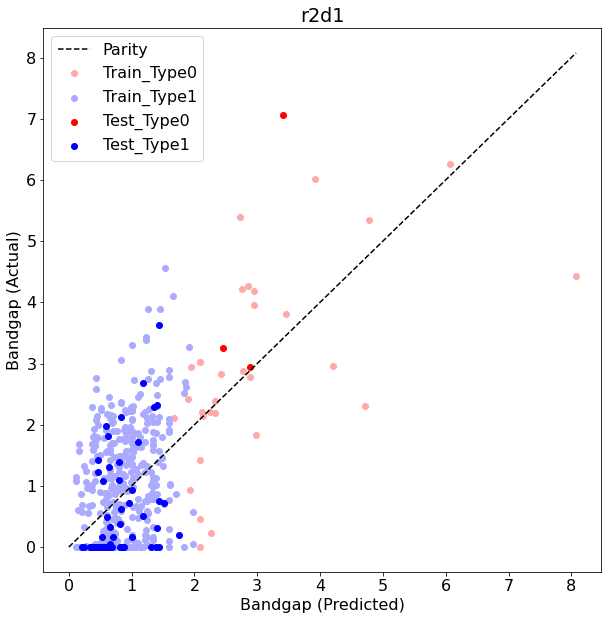

In [248]:
make_plot('r2d1')

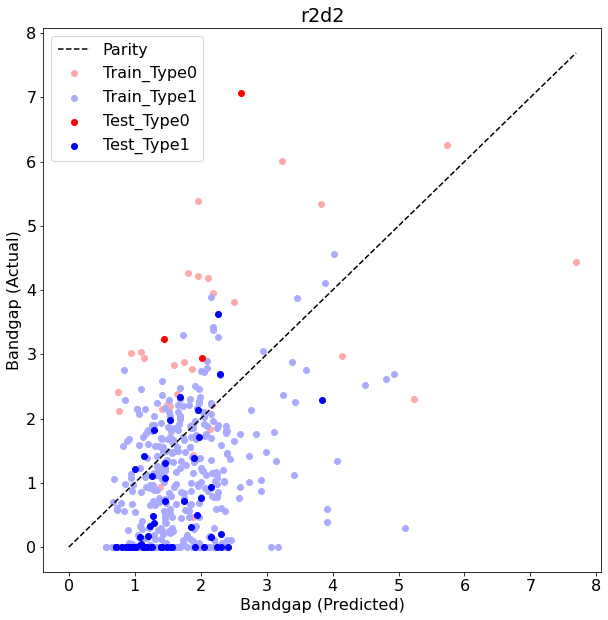

In [249]:
make_plot('r2d2')

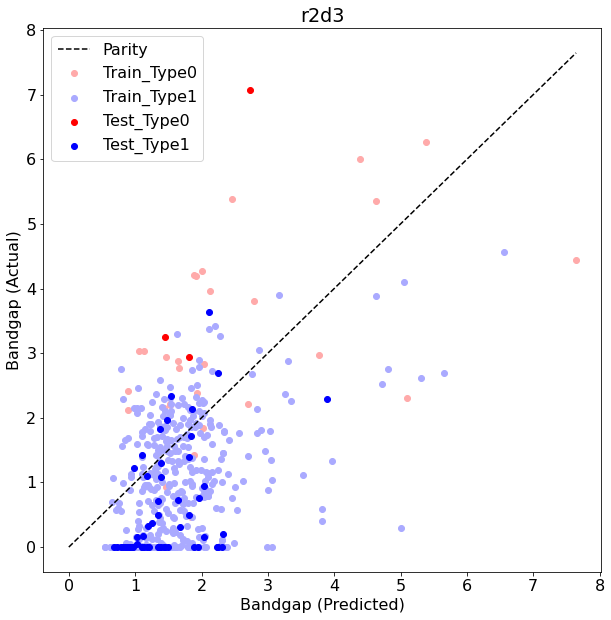

In [250]:
make_plot('r2d3')

# Histplots

In [363]:
import seaborn as sns

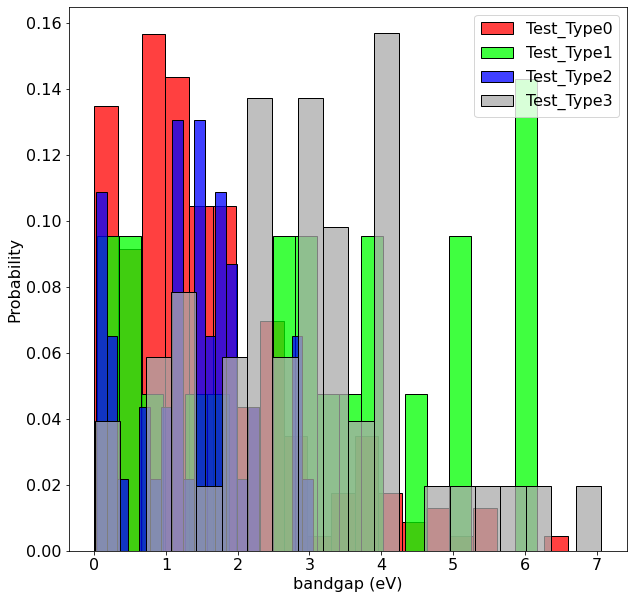

In [364]:
nbin = 20
sns.histplot(train[train['soap_label']==0]['bandgap (eV)'], bins=nbin, color='#FF0000', label='Test_Type0', stat='probability')
sns.histplot(train[train['soap_label']==1]['bandgap (eV)'], bins=nbin, color='#00FF00', label='Test_Type1', stat='probability')
sns.histplot(train[train['soap_label']==2]['bandgap (eV)'], bins=nbin, color='#0000FF', label='Test_Type2', stat='probability')
sns.histplot(train[train['soap_label']==3]['bandgap (eV)'], bins=nbin, color='#AAAAAA', label='Test_Type3', stat='probability')


plt.legend()

In [365]:
train[train['soap_label']==0][['2dm_id (unitless)', 'bandgap (eV)']]

,2dm_id (unitless),bandgap (eV)
5503,2dm-5514,0.8587
492,2dm-498,2.5821
3463,2dm-3474,1.9514
394,2dm-399,1.7259
5732,2dm-5743,0.5205
...,...,...
3496,2dm-3507,4.1537
3730,2dm-3741,0.5054
861,2dm-868,1.9297
4704,2dm-4715,0.7975


In [367]:
test[test['soap_label']==1]

,2dm_id (unitless),Total Angles (angles),Total Atoms (atoms),Total Bonds (bonds),alkaine_earth (atoms),alkaine_earth-chalcogen (bonds),alkaine_earth-chalcogen-alkaine_earth (angles),alkaine_earth-chalcogen-alkaline (angles),alkaine_earth-chalcogen-early_transition (angles),alkaine_earth-chalcogen-halide (angles),...,var:num_valance,var:period,var:sound_velocity,var:specific_heat,var:thermal_conductivity,var:vdw_radius,var:vdw_radius_alvarez,var:vdw_radius_mm3,var:vdw_radius_uff,soap_label
3896,2dm-3907,148,4,44.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.913580,1.333333,1.130754e+06,0.092665,51.867401,1096.222222,1489.777778,771.111111,688.534321,1
3846,2dm-3857,51,3,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.822222,1.440000,4.624293e+04,0.169190,11386.570014,589.982222,1699.040000,977.040000,1358.182400,1
3360,2dm-3371,144,2,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.555556,0.888889,1.227053e+05,0.163915,35550.631282,533.555556,1880.888889,672.222222,38.135556,1
1516,2dm-1525,94,2,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.555556,1.139992e+06,0.173132,449.067347,822.888889,1659.950617,730.246914,231.528889,1
3472,2dm-3483,51,3,18.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.782222,2.195556,4.346711e+04,0.184120,11442.988340,819.528889,1831.840000,829.440000,65.071289,1


In [368]:
import tpot

In [369]:
model = tpot.TPOTRegressor(
    generations=None,
    population_size=100,
    max_eval_time_mins=10/60,
    max_time_mins=1,
    cv=5,
    verbosity=2,
    scoring="neg_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=4,
    random_state=RANDOM_SEED
)
model.fit(features=train.drop(columns=regression_irrelevant + ['2dm_id (unitless)', 'formula']), target=train['bandgap (eV)'])

Imputing missing values in feature set


Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


1.09 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(SelectFromModel(input_matrix, max_features=0.4, n_estimators=100, threshold=0.05), normalize=False)


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

In [370]:
train

,Total Angles (angles),Total Atoms (atoms),Total Bonds (bonds),alkaine_earth (atoms),alkaine_earth-chalcogen (bonds),alkaine_earth-chalcogen-alkaine_earth (angles),alkaine_earth-chalcogen-alkaline (angles),alkaine_earth-chalcogen-early_transition (angles),alkaine_earth-chalcogen-halide (angles),alkaine_earth-chalcogen-pnictogen (angles),...,var:num_valance,var:period,var:sound_velocity,var:specific_heat,var:thermal_conductivity,var:vdw_radius,var:vdw_radius_alvarez,var:vdw_radius_mm3,var:vdw_radius_uff,soap_label
1805,6,2,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.640000,0.000000,9.946599e+05,0.035479,5.595040e-07,10.240000,64.000000,77.440000,140.185600,1
4465,18,3,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,64.250000,2.750000,8.639000e+05,0.178045,1.919308e+04,669.187500,1134.750000,692.687500,1148.722500,3
5098,16,3,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,103.222222,2.000000,1.835044e+06,0.079241,2.820298e+03,128.555556,679.222222,389.000000,220.075556,2
5503,60,3,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.600000,0.640000,2.925040e+05,0.039170,3.526960e+03,33.760000,303.360000,124.000000,48.098400,0
492,8,2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.555556,0.000000,2.130804e+05,0.124939,2.071577e+03,88.888889,450.000000,43.555556,6064.675556,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3730,21,2,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.888889,0.000000,1.391543e+06,0.109795,1.835372e+03,32.000000,648.000000,0.000000,4080.055556,0
861,18,2,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42.250000,0.250000,7.656250e+05,0.000041,1.374522e+04,9.000000,462.250000,12.250000,216.090000,0
4704,21,2,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.888889,0.222222,1.605556e+05,0.098336,9.821312e+02,162.000000,800.000000,200.000000,77.708889,0
3774,96,3,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.380165,0.925620,2.213436e+06,0.055687,5.709210e+02,380.066116,1047.652893,304.148760,1641.800165,0
